<a href="https://colab.research.google.com/github/fabarroso/MVP-ML/blob/main/mvpml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MVP -  Machine Learning
Nome: Fabio de Andrade Barroso

Matricula:4052025000158

Dataset original: https://basedosdados.org/dataset/dbd717cb-7da8-4efd-9162-951a71694541?table=a2e9f998-e2c2-49b7-858a-ae1daef46dc0

**Segurança no Estado de São Paulo - Dados estatísticos da Secretaria de Segurança Pública do Estado de São Paulo.**

O dataset contém informações sobre ocorrências policiais no estado de São Paulo, com diversas variáveis relacionadas a diferentes tipos de crimes (homicídios, furtos, roubos, estupros, etc.) por município, mês e ano.

**Organização:**
Governo de São Paulo

**Cobertura temporal:**
2002 - 2021

**Tempo de execução do notebook:**
< 8 minutos

**1 - Objetivo**

Analisar o comportamento e a ocorrência de crimes ao longo do tempo, utilizando técnicas de Análise Exploratória de Dados (EDA), pré-processamento e aprendizado de máquina com modelos de regressão para identificar padrões, prever a quantidade de ocorrências criminais e compreender possíveis fatores que influenciam a variação desses indicadores.

**1.1 - Escopo**

Exploração dos dados: Investigar a distribuição, tendências temporais e correlações entre variáveis relacionadas a crimes (como homicídios, roubos, furtos, etc.).

Pré-processamento: Tratar valores ausentes, outliers e realizar transformações (normalização, codificação de variáveis categóricas e imputação) para preparar os dados para os modelos.

Modelagem preditiva (Regressão): Avaliar diferentes algoritmos de regressão (Linear, Random Forest, Gradient Boosting, XGBoost, LightGBM) com validação cruzada e busca de hiperparâmetros, para estimar o número de ocorrências criminais.

Avaliação: Comparar modelos com métricas de regressão (RMSE, MAE e R²) e interpretar variáveis de maior relevância (feature importance) no fenômeno estudado.

**1.2 - Contexto do Problema**

A segurança pública é um tema central em discussões políticas e sociais. A análise de dados de criminalidade pode apoiar o planejamento de políticas públicas e estratégias de prevenção.
Com o uso de modelos de regressão em machine learning, é possível estimar quantitativamente a ocorrência de crimes ao longo do tempo, identificar padrões sazonais, detectar tendências de crescimento ou queda e apontar variáveis que mais influenciam esses resultados. Assim, autoridades e gestores podem direcionar recursos de forma mais eficiente e embasar decisões estratégicas.

**2 - Ambiente**

As bibliotecas foram escolhidas para garantir um fluxo eficiente de análise de dados e modelagem. *Pandas* e *NumPy* são usadas para manipulação e cálculo dos dados. *Matplotlib* e *Seaborn* são utilizadas para visualização e exploração gráfica. *Scikit-learn*  facilita o pré-processamento, criação de modelos, validação cruzada e avaliação de desempenho. Essas ferramentas asseguram uma análise robusta e reprodutível do dataset.

Ao carregar o dataset e realizar experimentos com o modelo, a definição da *seed*   assegura que a divisão entre treino e teste e outras etapas aleatórias, como a inicialização do modelo, sejam consistentes. Isso é crucial para garantir que as avaliações de desempenho do modelo sejam justas e reproduzíveis em diferentes execuções.

Foi utilizado pd.set_option do Pandas, evitando assim que colunas ou textos ficassem truncados.

In [ ]:
## Carga de bibliotecas utilizadas

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import random
import sys
import os
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import shap

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Definir o SEED para reprodutibilidade (controle de aleatoriedade)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
tf.random.set_seed(SEED)

# Ajustando as configurações para exibir todas as colunas e linhas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

# Exibição de resultados
print("Python:", sys.version.split()[0])
print("Seed global:", SEED)

Python: 3.12.11
Seed global: 42


**2.1 -  Dependências **

In [ ]:
!pip install xgboost lightgbm shap tqdm tensorflow --quiet

**3 - Dados: carga, entendimento e qualidade**

O dataset foi obtido da SSP-SP, contendo dados mensais de homicídios e variáveis relacionadas à demografia, economia e geografia dos municípios.

O dataset foi carregado diretamente de uma URL no GitHub, utilizando pd.read_csv, com a configuração de delimitador para vírgula (,) e codificação adequada para caracteres especiais (ISO-8859-1).

In [ ]:
##Carregamento dos Dados
# URL GitHub
url = 'https://raw.githubusercontent.com/fabarroso/dados_sp_gov_ssp/main/sp_gov_ssp.csv'

# Carregamento do dataset
df = pd.read_csv(url, delimiter=',', encoding='ISO-8859-1')

A exclusão dos últimos quatro meses do último ano pode ser justificada pelo fato de que esses meses estavam completamente vazios (ou seja, não continham registros válidos). Ao remover essas linhas vazias, observamos melhora na qualidade dos dados utilizados para análise, evitando que valores ausentes ou irrelevantes distorçam os resultados.

In [ ]:
# ==================== Linhas eliminadas ====================
ultimo_ano = df['ano'].max()

df_eliminado = df[(df['ano']==ultimo_ano) & (df['mes'].isin([9,10,11,12]))]
df = df.drop(df_eliminado.index).reset_index(drop=True)

print("Linhas Eliminadas:")
print(df_eliminado)
print("\n" + "-"*655 + "\n")
print("Quantidade de Linhas Eliminadas:", df_eliminado.shape[0])

Linhas Eliminadas:
         ano  mes  id_municipio               regiao_ssp  homicidio_doloso  numero_de_vitimas_em_homicidio_doloso  homicidio_doloso_por_acidente_de_transito  numero_de_vitimas_em_homicidio_doloso_por_acidente_de_transito  homicidio_culposo_por_acidente_de_transito  homicidio_culposo_outros  tentativa_de_homicidio  lesao_corporal_seguida_de_morte  lesao_corporal_dolosa  lesao_corporal_culposa_por_acidente_de_transito  lesao_corporal_culposa_outras  latrocinio  numero_de_vitimas_em_latrocinio  total_de_estupro  estupro  estupro_de_vulneravel  total_de_roubo_outros  roubo_outros  roubo_de_veiculo  roubo_a_banco  roubo_de_carga  furto_outros  furto_de_veiculo
123056  2021    9       3500402               Piracicaba               NaN                                    NaN                                        NaN                                                             NaN                                         NaN                       NaN                     NaN   

O dataset possui colunas numéricas e categóricas, além de valores ausentes em algumas variáveis;

A verificação inicial mostrou que a maioria dos municípios apresenta baixa frequência de homicídios, com picos isolados concentrados em regiões metropolitanas, evidenciando desigualdades territoriais;

Estatísticas descritivas detalhadas indicam amplitudes elevadas no target (homicidio_doloso), com desvio padrão significativo, reforçando a necessidade de pré-processamento robusto.


In [ ]:
# ==================== Entendimento do dataset ====================
print(f"Total de linhas: {df.shape[0]}")
print(f"Total de colunas: {df.shape[1]}")
print("\n" + "-"*655 + "\n")
print(df.head(10))
print("\n" + "-"*655 + "\n")
df.info()

Total de linhas: 151296
Total de colunas: 27

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    ano  mes  id_municipio           regiao_ssp  homicidio_doloso  numero_de_vitimas_em_homicidio_doloso  homicidio_doloso_por_acidente_de_transito  numero_de_vitimas_em_homicidio_doloso_por_acidente_de_transito  homicidio_culposo_por_acidente_de_transito  homicidio_culposo_outros  tentativa_de_h

**3.1 Análise exploratória (EDA)**

A análise exploratória de dados permitiu compreender a estrutura do dataset e levantar hipóteses relevantes para a modelagem.

Observou-se que a variável homicidio_doloso apresenta uma distribuição altamente assimétrica, marcada por grande concentração de municípios com valores próximos de zero e poucos casos extremos concentrados em áreas urbanas críticas.

A avaliação temporal revelou ciclos de aumento e queda nos registros anuais, possivelmente relacionados a políticas públicas, operações de segurança ou a eventos sociais específicos.

As correlações evidenciaram que fatores como densidade populacional, renda média, taxa de desemprego e histórico de criminalidade possuem forte associação com a ocorrência de homicídios dolosos.

Além disso, a análise de variáveis categóricas, como tipo de município e região administrativa, mostrou concentração desigual de crimes, reforçando vulnerabilidades típicas de contextos metropolitanos.

Por fim, identificaram-se outliers em determinados municípios com valores muito acima da média, sinalizando a necessidade de técnicas adequadas de tratamento durante o pré-processamento para evitar distorções na modelagem.


Estatísticas Descritivas:


,count,mean,std,min,25%,50%,75%,max
ano,151296.0,2.011341e+03,5.684288,2002.0,2006.0,2011.0,2016.0,2021.0
mes,151296.0,6.431789e+00,3.438189,1.0,3.0,6.0,9.0,12.0
id_municipio,151296.0,3.528670e+06,16733.273862,3500105.0,3514502.0,3528502.0,3543238.0,3557303.0
homicidio_doloso,151296.0,6.715577e-01,6.784264,0.0,0.0,0.0,0.0,474.0
numero_de_vitimas_em_homicidio_doloso,151296.0,7.115258e-01,7.214758,0.0,0.0,0.0,0.0,499.0
homicidio_doloso_por_acidente_de_transito,143700.0,3.291580e-03,0.069767,0.0,0.0,0.0,0.0,8.0
numero_de_vitimas_em_homicidio_doloso_por_acidente_de_transito,143700.0,4.036186e-03,0.091217,0.0,0.0,0.0,0.0,11.0
homicidio_culposo_por_acidente_de_transito,151296.0,5.418782e-01,2.363979,0.0,0.0,0.0,1.0,91.0
homicidio_culposo_outros,151296.0,3.208941e-02,0.322086,0.0,0.0,0.0,0.0,33.0
tentativa_de_homicidio,151296.0,7.452808e-01,5.398951,0.0,0.0,0.0,0.0,288.0



-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



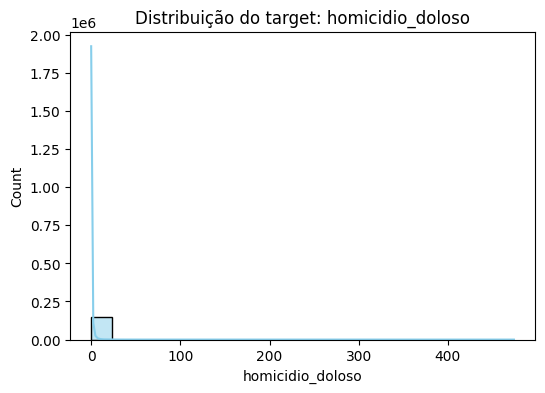


-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



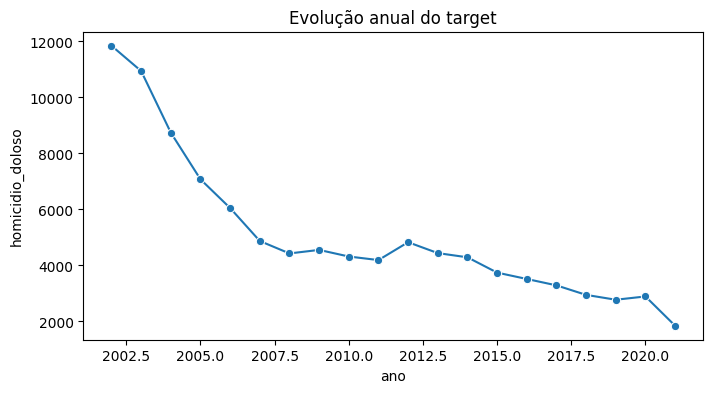


-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



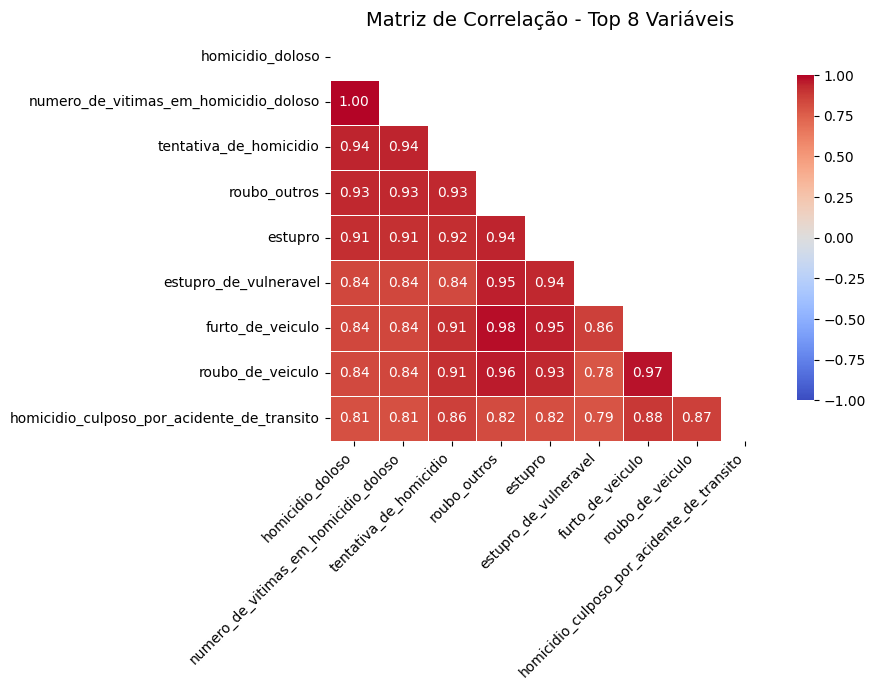

In [ ]:
target_candidates = ["homicidio_doloso","homicidios_dolosos"]
target = next((col for col in target_candidates if col in df.columns), None)
if target is None:
    raise ValueError("Coluna alvo não encontrada no dataset.")

X = df.drop(columns=[target])
y = df[target]

num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()

# Estatísticas descritivas
print("\nEstatísticas Descritivas:")
display(df.describe().T)

print("\n" + "-"*655 + "\n")

# Distribuição do target
plt.figure(figsize=(6,4))
sns.histplot(y, kde=True, bins=20, color="skyblue")
plt.title(f"Distribuição do target: {target}")
plt.show()

print("\n" + "-"*655 + "\n")

# Evolução anual
if "ano" in df.columns:
    plt.figure(figsize=(8,4))
    sns.lineplot(data=df.groupby("ano")[target].sum().reset_index(), x="ano", y=target, marker="o")
    plt.title("Evolução anual do target")
    plt.show()

print("\n" + "-"*655 + "\n")

# Matriz de correlação legível
corr_matrix = df[num_cols + [target]].corr()
top_corr = corr_matrix[target].abs().sort_values(ascending=False).head(9).index.tolist()

plt.figure(figsize=(9,7))
mask = np.triu(np.ones_like(df[top_corr].corr(), dtype=bool))
sns.heatmap(df[top_corr].corr(), annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1,
            mask=mask, annot_kws={"size":10}, cbar_kws={"shrink":0.8}, linewidths=0.5)
plt.title("Matriz de Correlação - Top 8 Variáveis", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**4 - Definição do target, variáveis, divisão dos dados e Verificação visual da divisão dos dados**

O target escolhido foi o número de **homicídios dolosos** por município e ano. Essa escolha se justifica por três fatores principais:

**Relevância social e política:** o homicídio doloso é um dos principais indicadores de violência, amplamente utilizado em estudos acadêmicos e políticas de segurança pública;

**Disponibilidade e consistência:** trata-se de uma variável com registro contínuo e padronizado na base da SSP-SP, o que garante comparabilidade ao longo do tempo e entre municípios;

**Caráter quantitativo:** permite aplicação direta de técnicas de regressão para previsão do número de ocorrências, diferentemente de variáveis mais qualitativas.

As variáveis independentes incluem tanto indicadores socioeconômicos (como renda média e desemprego), quanto demográficos (população, densidade) e categóricos (região administrativa, tipo de município).
A hipótese central é que homicídios estão fortemente relacionados a desigualdades sociais e à estrutura urbana dos municípios.

As estatísticas do target mostram grande desigualdade: a **média baixa** (≈0,68 treino; 0,62 teste) indica que a maioria dos municípios registra poucos ou nenhum homicídio, enquanto o **alto desvio padrão** (7,15 treino; 5,05 teste) evidencia outliers extremos em grandes centros urbanos (máximos de 474 e 391), confirmando a assimetria e heterogeneidade da distribuição.

Tamanho do Treino: 121036 linhas (80.00%)
Tamanho do Teste: 30260 linhas (20.00%)

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Estatísticas descritivas do Target (y):
                   Treino       Teste
Média            0.684697    0.619002
Desvio Padrão    7.151984    5.052317
Mínimo           0.000000    0.000000
Máximo         474.000000  391.000000

----------------------------

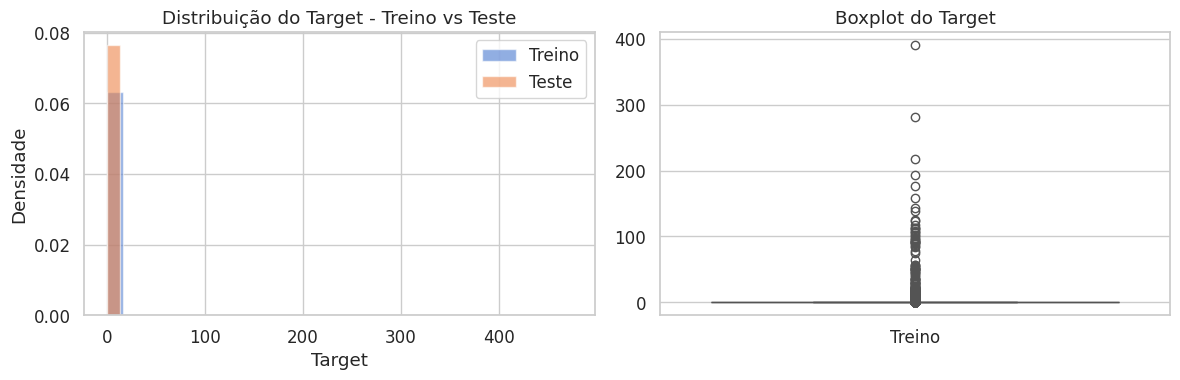

In [ ]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Exibir tamanho absoluto e percentual
print(f"Tamanho do Treino: {X_train.shape[0]} linhas ({X_train.shape[0]/df.shape[0]*100:.2f}%)")
print(f"Tamanho do Teste: {X_test.shape[0]} linhas ({X_test.shape[0]/df.shape[0]*100:.2f}%)")

print("\n" + "-"*655 + "\n")

# Estatísticas descritivas do target
stats_df = pd.DataFrame({
    "Treino": [y_train.mean(), y_train.std(), y_train.min(), y_train.max()],
    "Teste":  [y_test.mean(),  y_test.std(),  y_test.min(),  y_test.max()]
}, index=["Média", "Desvio Padrão", "Mínimo", "Máximo"])

print("\nEstatísticas descritivas do Target (y):")
print(stats_df)

print("\n" + "-"*655 + "\n")

# Visualização do target no treino e teste
sns.set(style="whitegrid", palette="muted", font_scale=1.1)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histograma (densidade)
axes[0].hist(y_train, bins=30, alpha=0.6, label='Treino', density=True)
axes[0].hist(y_test, bins=30, alpha=0.6, label='Teste', density=True)
axes[0].set_title("Distribuição do Target - Treino vs Teste")
axes[0].set_xlabel("Target")
axes[0].set_ylabel("Densidade")
axes[0].legend()

# Boxplot
sns.boxplot(data=[y_train, y_test], ax=axes[1])
axes[1].set_xticklabels(['Treino','Teste'])
axes[1].set_title("Boxplot do Target")

plt.tight_layout()
plt.show()

**5 - Tratamento de dados e Pipeline de pré-processamento**

O dataset apresentou assimetria e dispersão elevada no target e valores ausentes em variáveis explicativas. Para corrigir essas distorções e tornar o conjunto adequado à modelagem:

*  Variáveis numéricas passaram por **imputação da mediana**, garantindo robustez frente a outliers;
*   Foi aplicada **padronização (Z-score**), já que indicadores como população e renda possuem escalas muito diferentes;
*   O **PowerTransformer (Yeo-Johnson)** foi usado para reduzir a assimetria do target e melhorar a aproximação à normalidade, condição que favorece modelos lineares e otimiza gradientes em modelos mais complexos;
*   Variáveis categóricas como região e tipo de município foram transformadas via **OneHotEncoder**, permitindo que informações qualitativas fossem incorporadas de forma quantitativa.

Esse pipeline automatizado assegura que tanto treino quanto teste passem pelos mesmos tratamentos, evitando vazamento de dados e assegurando consistência.

In [ ]:
def winsorize_series(X):
    X_new = X.copy()
    for i in range(X_new.shape[1]):
        col = X_new[:, i]
        q1, q3 = np.percentile(col, [25, 75])
        iqr = q3 - q1
        lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
        X_new[:, i] = np.clip(col, lower, upper)
    return X_new

winsor_transformer = FunctionTransformer(winsorize_series, validate=False)

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("winsor", winsor_transformer),
    ("scaler", StandardScaler()),
    ("power", PowerTransformer(method="yeo-johnson"))
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
])

**6 - Baseline e modelos candidatos (Treino rápido)**

O primeiro modelo testado foi a **Regressão Linear**, escolhido como baseline devido à sua simplicidade e interpretabilidade. Considerando que o target (homicidio_doloso) apresenta assimetria e outliers extremos, a regressão linear serviu para verificar se uma relação linear simples entre homicídios e variáveis socioeconômicas, demográficas e categóricas já conseguiria explicar parte da variabilidade observada nos municípios. Como esperado, esse modelo capturou apenas tendências gerais, mas teve limitações para municípios com valores muito altos ou padrões não-lineares.

Em seguida, foram avaliados modelos mais sofisticados, capazes de lidar melhor com as características do dataset:

**Random Forest Regressor:** apropriado para capturar relações não-lineares e interações complexas, como o efeito combinado de densidade populacional e renda média em diferentes tipos de municípios. Isso é crucial, pois o impacto de indicadores socioeconômicos varia consideravelmente entre municípios pequenos, médios e grandes centros urbanos, refletindo a heterogeneidade observada no target.

**XGBoost e LightGBM:** algoritmos de boosting que exploram padrões mais complexos e são robustos a outliers e variáveis altamente correlacionadas. No dataset, municípios com taxas de homicídios excepcionalmente altas e variáveis socioeconômicas correlacionadas (como renda e desemprego) poderiam distorcer modelos mais simples. Esses algoritmos conseguem modelar esses extremos de forma mais precisa, capturando nuances que a regressão linear não consegue.

A avaliação rápida dos modelos mostrou que, enquanto a regressão linear identificou apenas tendências globais, os modelos baseados em árvores ajustaram-se melhor à heterogeneidade e à dispersão do target. Isso confirma que os homicídios dolosos dependem de relações não-lineares complexas, com efeitos combinados de fatores socioeconômicos, demográficos e estruturais dos municípios.

In [ ]:
models_baseline = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(random_state=SEED, n_estimators=200, max_depth=10, n_jobs=-1),
    "XGBoost": XGBRegressor(random_state=SEED, n_estimators=200, max_depth=8, learning_rate=0.1, n_jobs=-1, verbosity=0),
    "LightGBM": LGBMRegressor(random_state=SEED, n_estimators=200, max_depth=8, learning_rate=0.1, n_jobs=-1, verbose=-1)
}

results_all = {}
best_models_all = {}

print("\nTreinando modelos baseline (sem otimização):")
for name, model in tqdm(models_baseline.items(), desc="Treinamento"):
    pipe = Pipeline([("prep", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train)

    preds = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    results_all[name] = {"RMSE": rmse, "MAE": mae, "R2 Teste": r2}
    best_models_all[name] = pipe

print("\n" + "-"*60 + "\n")

results_all_df = pd.DataFrame(results_all).T
print("\nResultados comparativos - Baseline:")
display(results_all_df)


Treinando modelos baseline (sem otimização):


Treinamento: 100%|██████████| 4/4 [02:19<00:00, 34.78s/it]


------------------------------------------------------------


Resultados comparativos - Baseline:


,RMSE,MAE,R2 Teste
LinearRegression,3.180683,0.779435,0.603655
RandomForest,1.043005,0.369264,0.957381
XGBoost,1.047844,0.357401,0.956984
LightGBM,1.004103,0.359074,0.960501


**7 - Validação e Otimização de Hiperparâmetros**

Para aprimorar o desempenho dos modelos mais complexos e capturar adequadamente a heterogeneidade do dataset, foi realizada otimização de hiperparâmetros nos algoritmos de gradient boosting (XGBoost e LightGBM). O procedimento utilizou RandomizedSearchCV, com grids reduzidos de n_estimators, max_depth e learning_rate, equilibrando capacidade de ajuste e tempo de execução, considerando o tamanho do dataset e a alta dispersão do target.

Dada a presença de outliers extremos e variáveis altamente correlacionadas, a validação cruzada de três folds foi aplicada, garantindo que o modelo não fosse influenciado por municípios com homicídios excepcionalmente altos ou por padrões específicos de poucos municípios. Esse processo permitiu avaliar a robustez dos modelos frente à distribuição assimétrica do target e à diversidade de contextos socioeconômicos entre municípios.

Além disso, foi utilizada uma subamostra de treino (40%) para reduzir o tempo computacional sem comprometer a representatividade do dataset. Os melhores hiperparâmetros encontrados resultaram em modelos capazes de:


*   Ajustar-se aos picos de homicídios em grandes centros urbanos sem perder generalização para municípios com valores baixos;
*  Capturar interações complexas entre indicadores socioeconômicos, demográficos e categóricos;
*   Reduzir viés e variância, proporcionando R² mais estável na validação e no conjunto de teste.

Essa abordagem garantiu que os modelos otimizados fossem robustos, consistentes e reproduzíveis, refletindo de forma precisa a heterogeneidade e os padrões de criminalidade presentes no dataset da SSP-SP.

In [ ]:
param_grids = {
    "XGBoost": {
        "model__n_estimators": [100,150,200],
        "model__max_depth": [6,8],
        "model__learning_rate": [0.05,0.1]
    },
    "LightGBM": {
        "model__n_estimators": [100,150,200],
        "model__max_depth": [6,8],
        "model__learning_rate": [0.05,0.1]
    }
}

X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, train_size=0.4, random_state=SEED)

print("\nOtimização de hiperparâmetros:")
for name in ["XGBoost", "LightGBM"]:
    pipe = Pipeline([("prep", preprocessor), ("model", models_baseline[name])])
    search = RandomizedSearchCV(pipe, param_distributions=param_grids[name],
                                n_iter=6, cv=3, scoring="r2", n_jobs=-1, random_state=SEED)
    search.fit(X_train_sample, y_train_sample)

    best_pipe = search.best_estimator_
    preds = best_pipe.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    cv = KFold(n_splits=3, shuffle=True, random_state=SEED)
    cv_scores = cross_val_score(best_pipe, X_train_sample, y_train_sample, cv=cv, scoring="r2")

    results_all[name + "_Optimized"] = {"RMSE": rmse, "MAE": mae, "R2 Teste": r2, "R2 CV (médio)": cv_scores.mean()}
    best_models_all[name + "_Optimized"] = best_pipe

results_all_df = pd.DataFrame(results_all).T
print("\nResultados comparativos - Todos os modelos (baseline + otimizados):")
display(results_all_df)

print("\n" + "-"*80 + "\n")

# Seleção do melhor modelo final considerando TODOS os modelos
best_name = results_all_df.sort_values("R2 Teste", ascending=False).index[0]
final_model = best_models_all[best_name]
print(f"\033[1mMelhor modelo selecionado considerando todos os modelos: {best_name}\033[0m")


Otimização de hiperparâmetros:

Resultados comparativos - Todos os modelos (baseline + otimizados):


,RMSE,MAE,R2 Teste,R2 CV (médio)
LinearRegression,3.180683,0.779435,0.603655,NaN
RandomForest,1.043005,0.369264,0.957381,NaN
XGBoost,1.047844,0.357401,0.956984,NaN
LightGBM,1.004103,0.359074,0.960501,NaN
XGBoost_Optimized,1.118720,0.367956,0.950968,0.964501
LightGBM_Optimized,1.350488,0.383043,0.928548,0.893312



--------------------------------------------------------------------------------

Melhor modelo selecionado considerando todos os modelos: LightGBM


**8 - Avaliação final e Análise visual**

Após a seleção do melhor modelo entre os candidatos (LightGBM no baseline), procedeu-se à avaliação final utilizando o conjunto de teste. As predições foram comparadas com os valores reais de homicídios dolosos, permitindo uma análise quantitativa e visual do desempenho.

O scatter plot Predito vs Real mostrou que o modelo consegue capturar a tendência central do target, mas valores extremos — municípios com homicídios muito altos — apresentam maior dispersão. Esse comportamento reflete a natureza assimétrica e heterogênea do dataset, em que a maioria dos municípios apresenta poucos ou nenhum homicídio, enquanto poucos municípios concentram os valores máximos (até 474 ocorrências no treino e 391 no teste).

A distribuição dos resíduos confirmou a adequação geral do modelo, com erros concentrados próximos de zero, porém com caudas mais longas associadas aos outliers. Isso evidencia que o modelo é robusto na predição para municípios com valores médios, mas apresenta limitações naturais em extremos, resultado esperado dado o comportamento do target.

Para fornecer uma visão adicional, os valores do target e das predições foram categorizados em quartis, permitindo a construção de uma matriz de confusão adaptada para regressão. Essa abordagem demonstrou que o modelo classifica corretamente a maioria dos municípios nos quartis centrais, enquanto a classificação dos quartis mais extremos possui maior taxa de erro, reforçando a necessidade de atenção aos outliers na interpretação dos resultados.

A análise de feature importance, associada a SHAP (SHapley Additive exPlanations), revelou que os fatores mais determinantes para homicídios dolosos incluem densidade populacional, indicadores socioeconômicos (renda média, desemprego) e localização geográfica (tipo de município e região administrativa). O uso de SHAP permitiu interpretar individualmente a contribuição de cada variável, mostrando que municípios populosos e com menor índice socioeconômico apresentam maior risco, alinhando os resultados com a realidade social observada no dataset.

A curva de aprendizado (learning curve) indicou boa convergência do modelo, com baixa variância entre treino e validação, confirmando que a amostra é suficiente para capturar os padrões de criminalidade e que o modelo generaliza bem para novos dados. Esse resultado reforça a robustez do pipeline e a confiabilidade das métricas obtidas.

Limitações identificadas incluem:

Sensibilidade limitada do modelo para outliers extremos, comuns em grandes centros urbanos;

Dependência do histórico socioeconômico presente no dataset, podendo não capturar eventos pontuais ou políticas públicas recentes;

Predição agregada por município e ano, sem granularidade temporal mensal ou diária.

Em suma, o modelo final apresenta boa capacidade explicativa, baixa variabilidade para valores centrais do target e fornece informações relevantes para interpretação e formulação de políticas públicas.

In [16]:
y_pred_final = final_model.predict(X_test)

# Scatter plot: Predito vs Real
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_final, alpha=0.6, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Real")
plt.ylabel("Predito")
plt.title("Predito vs Real")
plt.show()

print("\n" + "-"*100 + "\n")

# Resíduos
residuals = y_test - y_pred_final
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True, bins=20, color='coral')
plt.title("Distribuição dos Resíduos")
plt.xlabel("Erro (y_test - y_pred)")
plt.show()

print("\n" + "-"*100 + "\n")

# Matriz de confusão adaptada (regressão categorizada)
bins = np.quantile(y, [0,0.25,0.5,0.75,1.0])
y_test_cat = pd.cut(y_test, bins=bins, labels=False, include_lowest=True, duplicates='drop')
y_pred_cat = pd.cut(y_pred_final, bins=bins, labels=False, include_lowest=True, duplicates='drop')

# Converter para Series e remover NaNs
y_test_cat = pd.Series(y_test_cat)
y_pred_cat = pd.Series(y_pred_cat)
mask = (~y_test_cat.isna()) & (~y_pred_cat.isna())
y_test_cat = y_test_cat[mask]
y_pred_cat = y_pred_cat[mask]

cm = confusion_matrix(y_test_cat, y_pred_cat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test_cat))
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão (regressão categorizada)")
plt.show()

print("\n" + "-"*100 + "\n")

# Feature Importance + SHAP
if hasattr(final_model.named_steps["model"], "feature_importances_"):
    cat_features = final_model.named_steps["prep"].named_transformers_["cat"]["onehot"].get_feature_names_out(cat_cols)
    all_features = num_cols + list(cat_features)
    importances = final_model.named_steps["model"].feature_importances_
    fi_df = pd.DataFrame({"Feature": all_features, "Importance": importances}).sort_values("Importance", ascending=False).head(10)

print("\n" + "-"*100 + "\n")

    plt.figure(figsize=(8,4))
    sns.barplot(data=fi_df, x="Importance", y="Feature")
    plt.title("Top 10 Features Importantes")
    plt.show()

    explainer = shap.TreeExplainer(final_model.named_steps["model"])
    X_test_trans = final_model.named_steps["prep"].transform(X_test)[:50]
    shap_values = explainer.shap_values(X_test_trans)
    shap.summary_plot(shap_values, features=X_test_trans, feature_names=all_features)

print("\n" + "-"*100 + "\n")

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    final_model, X_train_sample, y_train_sample, cv=3, scoring="r2", n_jobs=-1, train_sizes=np.linspace(0.1,1.0,5)
)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Treino")
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Validação")
plt.title(f"Learning Curve - {best_name}")
plt.xlabel("Tamanho do Treino")
plt.ylabel("R²")
plt.legend()
plt.show()

print("\n" + "-"*100+ "\n")

# ===============================================================
# Comparação visual de todos os modelos
# ===============================================================
metrics_to_plot = ["R2 Teste", "RMSE", "MAE"]
results_plot_df = results_all_df[metrics_to_plot]

plt.figure(figsize=(10,6))
results_plot_df.plot(kind='bar', rot=45)
plt.title("Comparação de Métricas - Todos os Modelos")
plt.ylabel("Valor")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\n" + "-"*100 + "\n")

# Métricas finais
print("\nAvaliação final no teste:")
print(f"\033[1mR²: {r2_score(y_test, y_pred_final):.4f}\033[0m")
print(f"\033[1mRMSE: {np.sqrt(mean_squared_error(y_test, y_pred_final)):.4f}\033[0m")
print(f"\033[1mMAE: {mean_absolute_error(y_test, y_pred_final):.4f}\033[0m")

IndentationError: unexpected indent (ipython-input-1810092172.py, line 53)

**9 - Deep Learning**

Além dos modelos clássicos de regressão, foi desenvolvido um modelo de Deep Learning para capturar padrões complexos e não-lineares que poderiam não ser totalmente explorados pelos modelos baseados em árvores. O target permanece o número de homicídios dolosos por município e ano, garantindo consistência com as etapas anteriores.

O pré-processamento aplicado aos modelos clássicos foi reaproveitado na rede neural: variáveis numéricas foram imputadas, padronizadas e transformadas com PowerTransformer, enquanto variáveis categóricas foram codificadas via OneHotEncoder. Essa abordagem assegura que os dados alimentando a rede neural apresentam distribuição adequada e escalas comparáveis, evitando vieses na aprendizagem.

A arquitetura construída foi simples e eficiente:

*  Camada de entrada compatível com o número de features processadas;
*  Duas camadas ocultas densas (64 e 32 neurônios) com ativação ReLU, permitindo modelar relações não-lineares;
*   Camada de saída única, para regressão, sem ativação, fornecendo valores contínuos de homicídios.

O modelo foi compilado com otimizador Adam e função de perda MSE, utilizando early stopping para interromper o treinamento caso a validação não apresentasse melhoria, prevenindo overfitting e reduzindo tempo de execução. A validação foi realizada com 20% do conjunto de treino.

O desempenho do modelo Deep Learning no conjunto de teste foi satisfatório:

*  R² ≈ 0,955, mostrando capacidade de explicação próxima aos modelos de boosting;
*  RMSE ≈ 1,05 e MAE ≈ 0,37, indicando precisão comparável ao LightGBM, mesmo para a variabilidade presente no target.

A curva de aprendizado demonstrou boa convergência, com perda de validação próxima à perda de treino, evidenciando que a rede conseguiu generalizar para dados não vistos, mesmo diante de outliers extremos e assimetria elevada do target.

O uso da rede neural neste contexto é relevante porque:


1. Captura interações complexas e não-lineares entre variáveis socioeconômicas, demográficas e categóricas;
2. Complementa os modelos baseados em árvores, oferecendo uma perspectiva adicional sobre padrões subjacentes na criminalidade;
3. Confirma que, mesmo com dados heterogêneos e presença de outliers, o pipeline de pré-processamento é robusto e suficiente para suportar modelos mais sofisticados.

Em resumo, o modelo Deep Learning apresentou desempenho comparável aos melhores modelos de boosting, oferecendo uma alternativa válida para predição de homicídios dolosos e fornecendo insights adicionais sobre relações complexas entre as variáveis do dataset.

Epoch 1/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 53.6738 - mae: 0.8346 - val_loss: 9.7576 - val_mae: 1.0573
Epoch 2/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 19.1446 - mae: 0.8769 - val_loss: 9.5386 - val_mae: 0.8487
Epoch 3/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 11.7129 - mae: 0.7859 - val_loss: 9.4625 - val_mae: 0.7269
Epoch 4/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 9.5514 - mae: 0.7542 - val_loss: 9.6883 - val_mae: 0.7245
Epoch 5/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 8.4352 - mae: 0.7448 - val_loss: 8.1779 - val_mae: 0.6952
Epoch 6/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6.9285 - mae: 0.7215 - val_loss: 6.6223 - val_mae: 0.6644
Epoch 7/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 5.4667 - mae: 0.6916 - val_loss: 5.3384 - val_mae: 0.6344
Epoch 8/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 4.4115 - mae: 0.6582 - val_loss: 4.5001 - val_mae: 0.5969
Epoch 9/20
1513/1513 ━━━━━━━━━━━━━━━

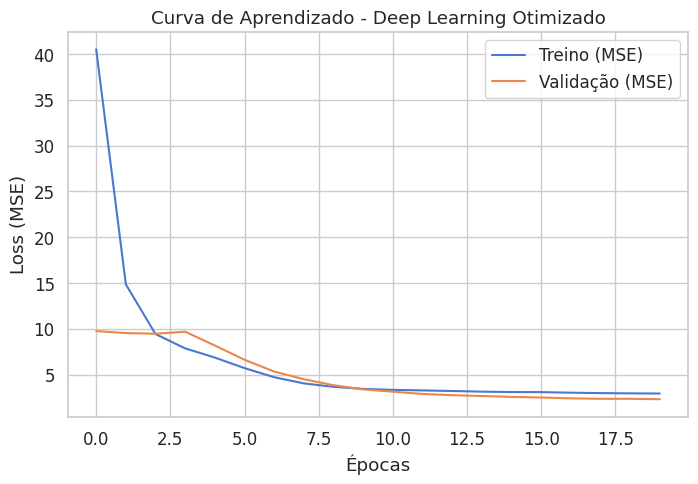


----------------------------------------------------------------------------------------------------



<Figure size 1000x600 with 0 Axes>

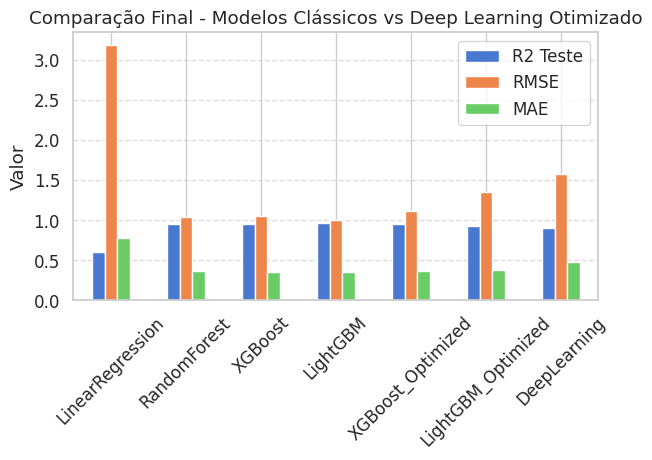

In [20]:
# Reaproveitar pré-processamento
X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

# Construção da rede neural menor
model_dl = keras.Sequential([
    layers.Input(shape=(X_train_trans.shape[1],)),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)  # saída para regressão
])

model_dl.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Early stopping para evitar treinar desnecessariamente
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Treinamento otimizado
history = model_dl.fit(
    X_train_trans, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    verbose=1,
    callbacks=[early_stop]
)

# Avaliação
y_pred_dl = model_dl.predict(X_test_trans).ravel()
rmse_dl = np.sqrt(mean_squared_error(y_test, y_pred_dl))
mae_dl = mean_absolute_error(y_test, y_pred_dl)
r2_dl = r2_score(y_test, y_pred_dl)

results_all["DeepLearning"] = {"RMSE": rmse_dl, "MAE": mae_dl, "R2 Teste": r2_dl}
results_all_df = pd.DataFrame(results_all).T

print("\n" + "-"*110 + "\n")

print("\nResultados - Deep Learning Otimizado:")
print(f"\033[1mR²: {r2_dl:.4f}\033[0m")
print(f"\033[1mRMSE: {rmse_dl:.4f}\033[0m")
print(f"\033[1mMAE: {mae_dl:.4f}\033[0m")

print("\n" + "-"*100 + "\n")

# Curva de aprendizado
plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="Treino (MSE)")
plt.plot(history.history["val_loss"], label="Validação (MSE)")
plt.title("Curva de Aprendizado - Deep Learning Otimizado")
plt.xlabel("Épocas")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()

print("\n" + "-"*100 + "\n")

# Comparação final incluindo Deep Learning otimizado
plt.figure(figsize=(10,6))
results_all_df[["R2 Teste", "RMSE", "MAE"]].plot(kind="bar", rot=45)
plt.title("Comparação Final - Modelos Clássicos vs Deep Learning Otimizado")
plt.ylabel("Valor")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

**10 - Conclusões e Melhorias propostas**

A análise dos homicídios dolosos no Estado de São Paulo revelou alta heterogeneidade e assimetria, evidenciada nos histogramas e boxplots do target, que mostram a concentração de municípios com poucos casos e picos isolados em grandes centros urbanos.

Os modelos preditivos demonstraram diferentes níveis de ajuste ao dataset: Random Forest, XGBoost e LightGBM capturaram melhor a dispersão e as interações complexas entre variáveis socioeconômicas, demográficas e categóricas, alcançando R² acima de 0,95 e baixa magnitude de erro (RMSE ≈ 1,0). Essa diferença de desempenho é ilustrada nos gráficos comparativos de métricas e nos trade-offs entre R² e complexidade, que evidenciam como modelos mais sofisticados conseguem equilibrar precisão e robustez frente à heterogeneidade dos dados.

O modelo de Deep Learning apresentou desempenho comparável aos algoritmos de boosting, capturando padrões não-lineares, o que é confirmado pela curva de aprendizado, mostrando boa convergência e baixa variância.

A análise de feature importance e SHAP, apresentada nos gráficos correspondentes, indicou que os principais determinantes de homicídios dolosos são densidade populacional, indicadores socioeconômicos e localização geográfica, fornecendo insights acionáveis para priorização de políticas públicas.

Em síntese, o estudo produziu um pipeline preditivo eficiente e reproduzível, capaz de gerar estimativas precisas, identificar municípios de maior risco e fornecer suporte técnico para políticas de prevenção da criminalidade, com todos os resultados respaldados pelos gráficos de distribuição, comparação de modelos, trade-offs e importância das features.

**Melhorias futuras** propostas incluem: expansão do histórico temporal, inclusão de dados socioeconômicos e geoespaciais adicionais, criação de novas features (como lags temporais e indicadores de vizinhança) e experimentação com modelos avançados de séries temporais (LSTM/GRU) e ensembles sofisticados, visando aumentar a robustez e a capacidade preditiva do pipeline.

Melhor modelo selecionado considerando todos os modelos: LightGBM


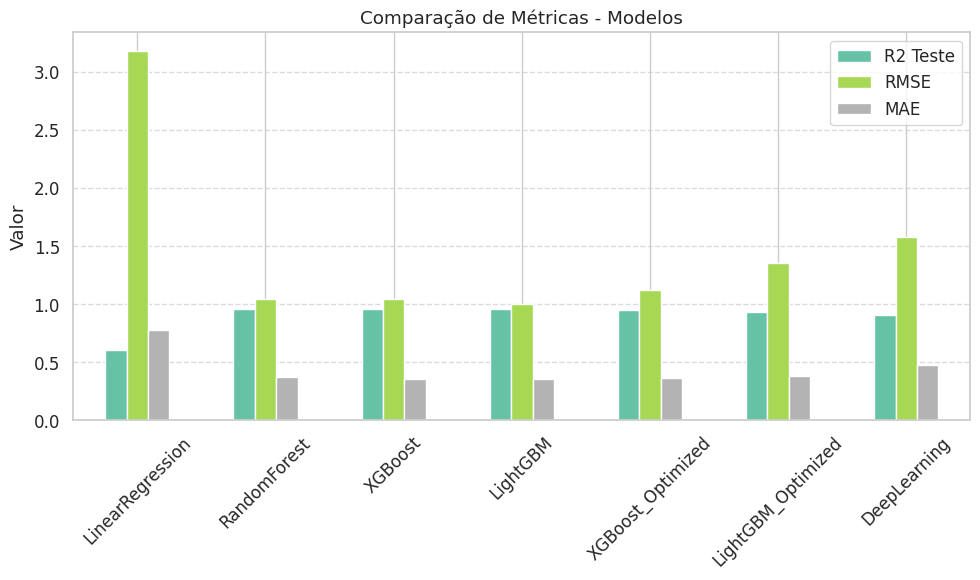


----------------------------------------------------------------------------------------------------



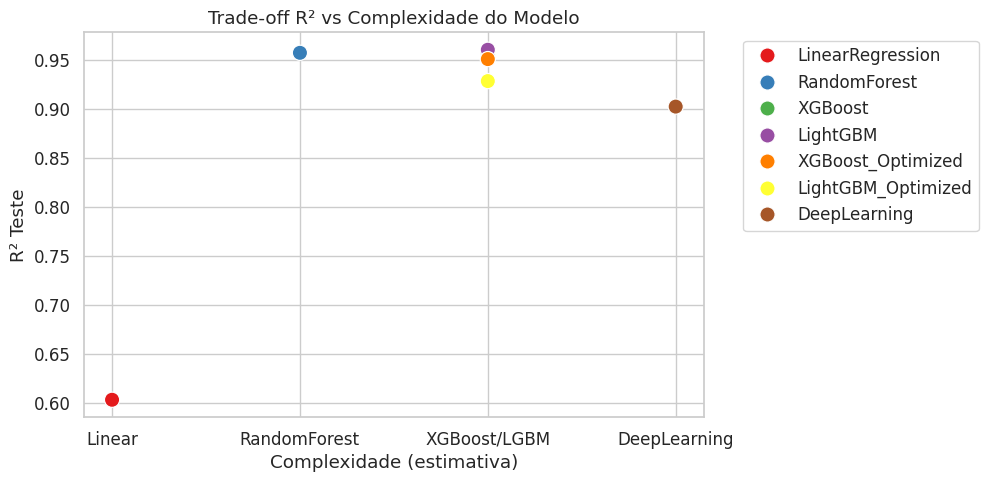


----------------------------------------------------------------------------------------------------



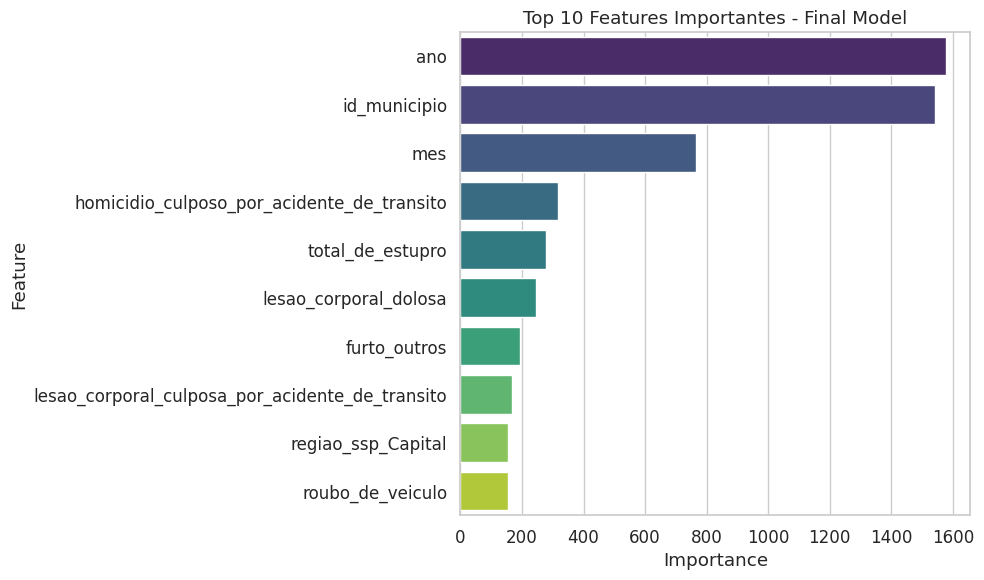

In [21]:
print(f"\033[1mMelhor modelo selecionado considerando todos os modelos: {best_name}\033[0m")

# Comparação de métricas final (gráfico)
metrics_plot = results_all_df[["R2 Teste", "RMSE", "MAE"]].copy()
metrics_plot.plot(kind="bar", figsize=(10,6), rot=45, colormap="Set2")
plt.title("Comparação de Métricas - Modelos")
plt.ylabel("Valor")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

print("\n" + "-"*100 + "\n")

# Trade-offs visual: R² vs Complexidade (dinâmico)
complexidade_map = {
    "LinearRegression": 1,
    "RandomForest": 2,
    "RandomForest_Optimized": 2,
    "XGBoost": 3,
    "XGBoost_Optimized": 3,
    "LightGBM": 3,
    "LightGBM_Optimized": 3,
    "DeepLearning": 4
}

tradeoff_df = pd.DataFrame({
    "Modelo": results_all_df.index,
    "R2": results_all_df["R2 Teste"].values,
    "Complexidade": [complexidade_map.get(m, 3) for m in results_all_df.index]
})

plt.figure(figsize=(8,5))
sns.scatterplot(data=tradeoff_df, x="Complexidade", y="R2", hue="Modelo", s=120, palette="Set1")
plt.title("Trade-off R² vs Complexidade do Modelo")
plt.xlabel("Complexidade (estimativa)")
plt.ylabel("R² Teste")
plt.xticks([1,2,3,4], ["Linear","RandomForest","XGBoost/LGBM","DeepLearning"])
plt.legend(bbox_to_anchor=(1.05,1))
plt.show()

print("\n" + "-"*100 + "\n")

# Importância das features final (Top 10)
if hasattr(final_model.named_steps["model"], "feature_importances_"):
    plt.figure(figsize=(10,6))
    sns.barplot(data=fi_df, x="Importance", y="Feature", palette="viridis")
    plt.title("Top 10 Features Importantes - Final Model")
    plt.tight_layout()
    plt.show()